# Kaggle - predicting bike rental count

**Description**: _You are provided hourly bike rental data spanning two years. For this task, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period._

Fields
- datetime - hourly date + timestamp  
- season -  
  - 1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

### **Table of Contents**
 - [Feature types and strategy](#feat_types)
  - Numerical (checking for normality)
  - Categorical
  - Binary
  - Date
 - [Numerical variable distributions and scaling](#num_dist)
     - [Data scaling](#scaling)
 - [Distribution of categorical variables](#cat_dist)
 - [Transformation of the target variable](#log_trans)
 - [Linear Regression](#lg)
 - [KNeighborsRegressor]
 - [Gradient Boosting Regressor]
 - [XGBoost]
 - [Results using GradientBoostingRegressor, KNeighborsRegressor, XGBRegressor](#results)

- [Appendix](#append):
 - [Pipeline demonstration using linear regression](#pipeline)
 - [GridCV for GBR](#gridcv)
 - Residuals distribution
 - [correlation and p-values on the features](#corr)



In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest, anderson
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV
from sklearn.feature_selection import f_regression

%matplotlib inline

In [30]:
train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [31]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [32]:
train_df.shape #(10886, 12)
test_df.shape #(6493, 9) 

(6493, 9)

In [33]:
#check the (inferred) feature types
train_df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

No missing data to handle!

In [34]:
#Any missing data to handle?
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
#No

,Total,Percent
count,0,0.0
registered,0,0.0
casual,0,0.0
windspeed,0,0.0
humidity,0,0.0
atemp,0,0.0
temp,0,0.0
weather,0,0.0
workingday,0,0.0
holiday,0,0.0


<a id="feat_types"></a>
## Feature types and strategy

- Numerical Variables: 
  - features: temp, atemp, humidity,  and windspeed 
  - Normalization or standardizing the data
   - **Why?** Having no other information that some features are more important than the others, the default is to standarize the input to have the same range ([0 to 1] or [-1 to 1] so that each will have equal importance. Features with higher ranges can have more "weight", distance or variance by contrast to features with smaller ranges in the ML algorithms I am using, like linear regression.  It doesn't matter for tree based methods as that is not using a distance or scale, but it won't hurt either.  For future data and deploying to production, it might be something to reconsider if the max and min could be different for any of the features that are not normally distributed.
   - Check whether they are a Guassian distribution or close to one.  If not, I will use normalization. 
- Categorical Variables: 
    - features: season, and weather
    - perform one hot encoding   
- Binary: 
  - features: holiday, and workingday 
  - already 0 and 1 so no processing is necessary  
- Date 
  - create a feature hour of the day as these are the time units and what we are predicting for. This is shown above.

In [35]:
train_df['datetime'] =  pd.to_datetime(train_df['datetime'], format='%Y-%m-%d %H:%M:%S')
train_df['hourofday'] = train_df['datetime'].dt.hour
test_df['datetime'] =  pd.to_datetime(test_df['datetime'], format='%Y-%m-%d %H:%M:%S')
test_df['hourofday'] = test_df['datetime'].dt.hour

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f86fa20>],
      dtype=object)

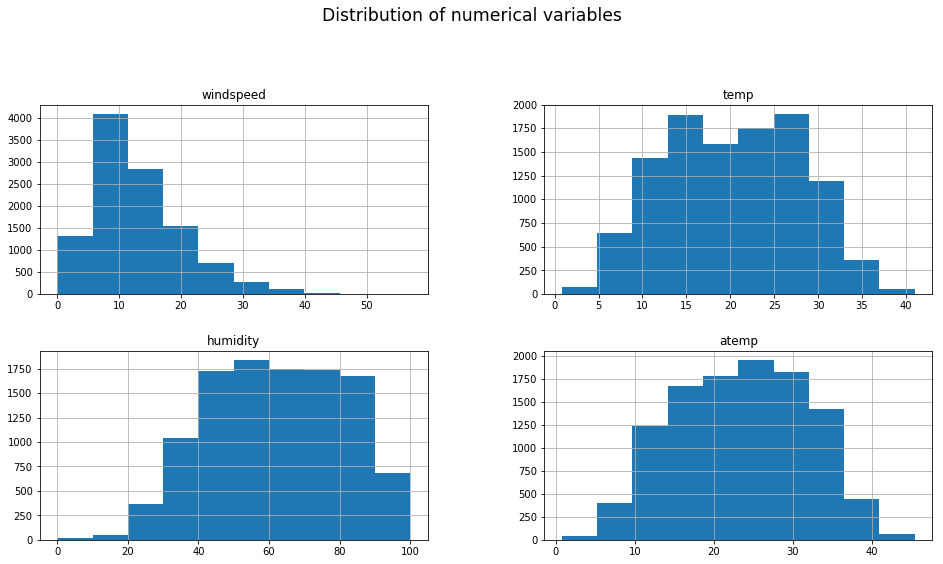

In [36]:
#plot the distribution of the numerical features to visually check
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 8, forward=True)
plt.suptitle('Distribution of numerical variables', x=0.5, y=1.05, ha='center', fontsize='xx-large')
train_df.hist(column='windspeed',ax=axes[0,0])
train_df.hist(column='humidity', ax=axes[1,0])
train_df.hist(column='temp', ax=axes[0,1])
train_df.hist(column='atemp', ax=axes[1,1])


<a id="num_dist"></a>
### Numerical variable distributions and scaling
Visually looking at the histograms, windspeed clearly does not look like a guassian (normal) distribution, the other three (temp,atemp, and humidity) are hard to tell.  It is possible that these three could be close enough to a guassian that that using standardization v.s. normalization will be OK for scaling the features.  
Below is a generic function that takes in a pandas series, then performs _[four popular ways to check for normality](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)_.
1. Quantile-Quantile Plot (QQPlot)
2. Shapiro-Wilk Test
3. D’Agostino’s K^2 Test
4. Anderson-Darling Test

**Results:**  All four of the features "failed" all four of the ways to check for a guassian distribution.

In [37]:
def normality_checks(feature_col):
    """
 will take in the feature column, series (slice) of the pandas df then
    1. plot the qqplot, 
    2. print the Shapiro-Wilk stats and pvalue
    3. skew and kurtosis normal test stats, 
    4. the anderson test results
    """
    print("\nResults of normality tests for the {0} feature:".format(feature_col.name))
    qqplot(feature_col, line='s')
    plt.show()
    stat, p = shapiro(feature_col)
    if feature_col.shape[0]>5000:
        print("Note: in the Shapiro-Wilk test for normality: for N > 5000 the W test statistic is accurate but the p-value may not be.")
    print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
    stat, p = normaltest(feature_col)
    print('D’Agostino’s K^2 Test statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    result = anderson(feature_col)
    print('Anderson-Darling test statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
 


Results of normality tests for the temp feature:


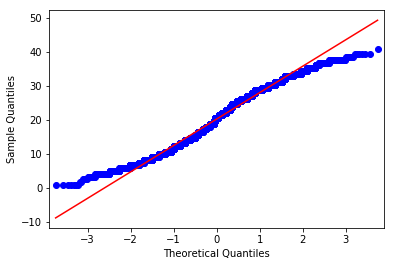

Note: in the Shapiro-Wilk test for normality: for N > 5000 the W test statistic is accurate but the p-value may not be.
Shapiro-Wilk statistics=0.980, p=0.000
D’Agostino’s K^2 Test statistics=1602.676, p=0.000
Sample does not look Gaussian (reject H0)
Anderson-Darling test statistic: 67.806
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)

Results of normality tests for the atemp feature:


/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


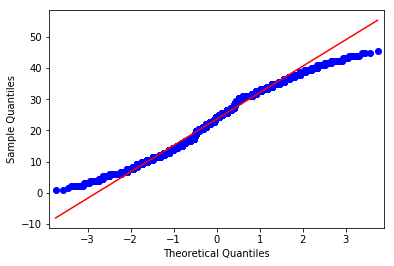

Note: in the Shapiro-Wilk test for normality: for N > 5000 the W test statistic is accurate but the p-value may not be.
Shapiro-Wilk statistics=0.982, p=0.000
D’Agostino’s K^2 Test statistics=1190.222, p=0.000
Sample does not look Gaussian (reject H0)
Anderson-Darling test statistic: 66.921
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)

Results of normality tests for the humidity feature:


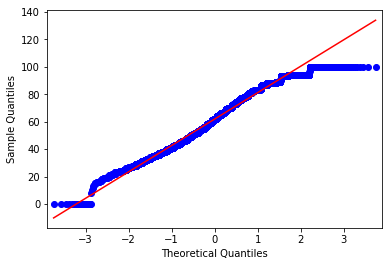

Note: in the Shapiro-Wilk test for normality: for N > 5000 the W test statistic is accurate but the p-value may not be.
Shapiro-Wilk statistics=0.982, p=0.000
D’Agostino’s K^2 Test statistics=776.283, p=0.000
Sample does not look Gaussian (reject H0)
Anderson-Darling test statistic: 51.138
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)

Results of normality tests for the windspeed feature:


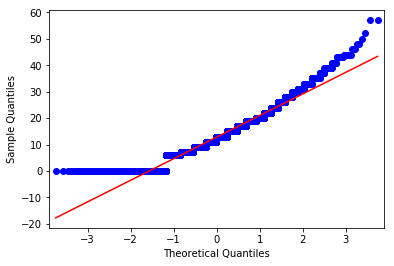

Note: in the Shapiro-Wilk test for normality: for N > 5000 the W test statistic is accurate but the p-value may not be.
Shapiro-Wilk statistics=0.959, p=0.000
D’Agostino’s K^2 Test statistics=650.631, p=0.000
Sample does not look Gaussian (reject H0)
Anderson-Darling test statistic: 98.057
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [38]:
numerical_features=['temp', 'atemp', 'humidity', 'windspeed']
#print the normality checks for the numerical features
for num_feature in numerical_features:
    normality_checks(train_df[num_feature])

<a id="scaling"></a>
### Data Scaling
I will proceed to choose a scaling option more ideal for non guassian distributions.  In addition to using the histograms above, the spread is checked by printing the mean and standard deviation to determine whether or I go with a standard scaler or a more robust one.  For more detail on scikit's Preprocessing data go [here](https://scikit-learn.org/stable/modules/preprocessing.html).  
I have decided to go with the **RobustScaler** because I see some outliers and the spread is siginificant relative mean.  This will scale the data to a slightly larger range than 1 or 2, by using the _median and interquartile range_ v.s. the _mean and variance_ AND they will each have different ranges but not as different than the original range.  My intution is factoring in the weight of the edge values for these features will be helpful information in determining the count of rentals.  [More helpful information on deciding how to scale is here.](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

  

      

temp: mean=20.230859819952173 standard deviation=7.791231963738185
atemp: mean=23.65508405291192 standard deviation=8.47421137445214
humidity: mean=61.88645967297446 standard deviation=19.24414932207303
windspeed: mean=12.799395406945093 standard deviation=8.164162316511634


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a23807b00>],
      dtype=object)

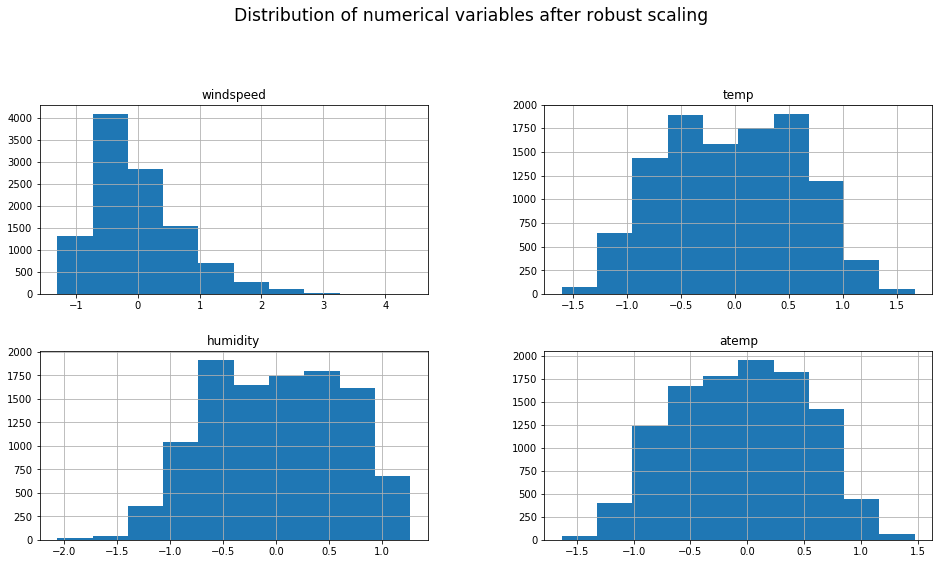

In [39]:
#print mean and std
for feat in numerical_features:
    mean=np.mean(train_df[feat])
    std=np.std(train_df[feat])
    print("{0}: mean={1} standard deviation={2}".format(feat,mean,std))

#Robust scaler will scale each feature in the list numeric_cols, and return a numpy matrix
train_robscaled=preprocessing.RobustScaler(quantile_range=(25, 75)).fit_transform(train_df[numerical_features])
#convert to a pandas dataframe with the headers
train_df_rscaled=pd.DataFrame(train_robscaled, dtype=float, columns=numerical_features)
#scale and distribution after the scaling
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 8, forward=True)
plt.suptitle('Distribution of numerical variables after robust scaling', x=0.5, y=1.05, ha='center', fontsize='xx-large')
train_df_rscaled.hist(column='windspeed',ax=axes[0,0])
train_df_rscaled.hist(column='humidity', ax=axes[1,0])
train_df_rscaled.hist(column='temp', ax=axes[0,1])
train_df_rscaled.hist(column='atemp', ax=axes[1,1])


<a id="cat_dist"></a>
### Distribution of categorical variables
The classes are relatively spread out, except for workday, holiday and weather type. Data is collected for every hour, so the bias is not from collection but from the weather in DC, and that there are more workdays than holidays in a year.

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hourofday'],
      dtype='object')


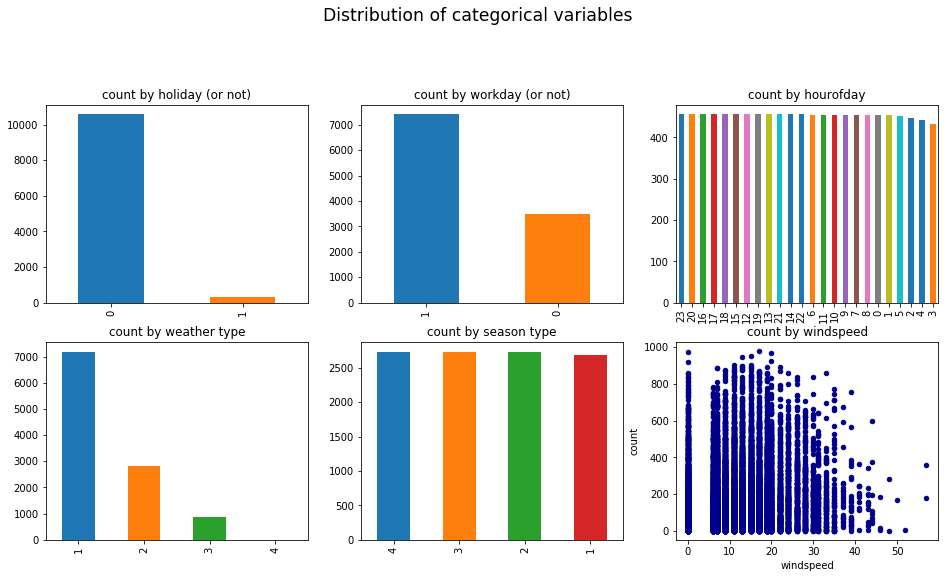

In [40]:

print(train_df.columns)
#pd.value_counts(train_df["weather"]).plot.bar()
#pd.value_counts(train_df["season"]).plot.bar()

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(16, 8, forward=True)
plt.suptitle('Distribution of categorical variables', x=0.5, y=1.05, ha='center', fontsize='xx-large')
pd.value_counts(train_df["holiday"]).plot.bar(ax=axes[0,0], title="count by holiday (or not)")
pd.value_counts(train_df["workingday"]).plot.bar(ax=axes[0,1], title="count by workday (or not)")
pd.value_counts(train_df["hourofday"]).plot.bar(ax=axes[0,2], title="count by hourofday")
pd.value_counts(train_df["weather"]).plot.bar(ax=axes[1,0], title="count by weather type")
pd.value_counts(train_df["season"]).plot.bar(ax=axes[1,1], title="count by season type")
#pd.value_counts(train_df["windspeed"]).plot(ax=axes[1,2], title="count by windspeed")
train_df.plot.scatter(x='windspeed',
                       y='count',
                       c='DarkBlue',ax=axes[1,2], title="count by windspeed")



<a id="log_trans"></a>
### Transformation of the target variable
I did not get good results with linear regression and got better results with Gradient Boosting and KNN.  [Log transformation of the target linearizes them](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html).  A comparison will be shown below in this notebook where linear regression is used.
Using the logarithm of one or more variables instead of the un-logged form makes the effective relationship non-linear, while still preserving the linear model.
Logarithmic transformations are also a convenient means of transforming a highly skewed variable into one that is more approximately normal.


Text(0.5,1.05,'Distribution of total count before and after log transform')

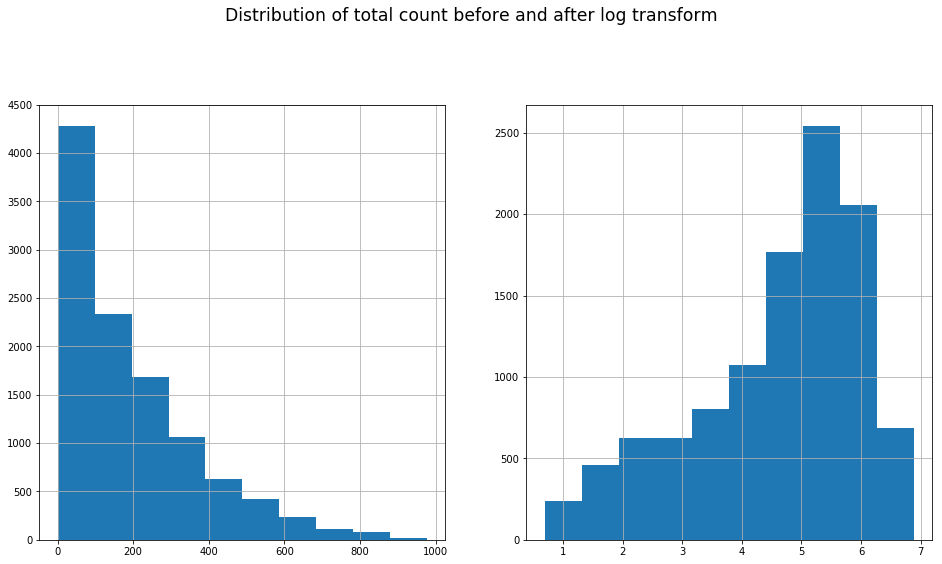

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 8, forward=True)
train_df['count'].hist(ax=axes[0])
y_trans = np.log1p(train_df['count'])
y_trans.hist()
plt.suptitle('Distribution of total count before and after log transform', x=0.5, y=1.05, ha='center', fontsize='xx-large')


In [43]:
#one hot encoding on the categorial fields, keeping the original columns

train_df = pd.concat([train_df, pd.get_dummies(train_df, columns = ['season','weather'] )], axis=1)
#train_df = pd.get_dummies(train_df, columns = ['season','weather'] )

In [75]:
#putting together the feature df and target df



cat_features=['holiday', 'workingday','hourofday', 'season_1',
       'season_2', 'season_3', 'season_4', 'weather_1', 'weather_2',
       'weather_3', 'weather_4']
#put the features together into one df
X=pd.concat([train_df_rscaled, train_df[cat_features]], axis=1)
train_df = train_df.loc[:,~train_df.columns.duplicated()]
y=train_df['count']  

#y_trans was created above, which is the log transformed target

#create training and test splits for the original and log transformed target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)#, random_state=30)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y_trans,test_size=0.3)


In [79]:
#create two linear regression models to compare the original and log transformed target
linear_model = LinearRegression()
linear_model2 = LinearRegression()

linear_model.fit(X_train, y_train)
linear_model2.fit(X_train2, y_train2)

y_pred_lg = linear_model.predict(X_test)
y_pred_lg2 = linear_model2.predict(X_test2)

score=linear_model.score(X_test,y_test)
score2=linear_model2.score(X_test2,y_test2)

rmse = mean_squared_error(y_test, linear_model.predict(X_test))**0.5
#rmse2 = mean_squared_error(y_test2, linear_model2.predict(X_test2))**0.5
mae=mean_absolute_error(y_test2, linear_model2.predict(X_test2))
scores = cross_val_score(linear_model, X, y, cv=3)
scores2 = cross_val_score(linear_model2, X, y_trans, cv=3)

print("Linear Regression results on original target")
print("Test score: {0}, RMSE: {1}".format(score, rmse))
print("Cross validation scores: {0}".format(scores))
print("Training score: {0}\n".format(linear_model.score(X_train,y_train)))
print("Linear Regression results on log transformed target")
print("Linear Regression test score: {0}, MAE: {1}".format(score2, mae))
print("Cross validation scores: {0}".format(scores2))
print("Training score: {0}\n".format(linear_model2.score(X_train2,y_train2)))

#additional option for improvement: adding interaction terms - any two variables

Linear Regression results on original target
Test score: 0.3530655440289421, RMSE: 147.2811507015047
Cross validation scores: [-0.08095366  0.13500295  0.14734384]
Training score: 0.34332754762425266

Linear Regression results on log transformed target
Linear Regression test score: 0.4596060518665407, MAE: 0.8194920977264387
Cross validation scores: [0.39669657 0.32998738 0.40589617]
Training score: 0.47977954191295535



<a id="lg"></a>
### Linear Regression results
Log transformation of the target helped give better results and more consistent cross validation scores, but they are still not great, even on the training set. RMSE is low for the log transformed since square distance will be a much smaller range.

In [67]:
# #GradientBoostingRegressor
# #params={'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
# #          'learning_rate': 0.01, 'loss': 'ls'}

#print(y_train['count'])
gbr_model=GradientBoostingRegressor()#**params)
gbr_model.fit(X_train, y_train)
score=gbr_model.score(X_test,y_test)
rmse = mean_squared_error(y_test, gbr_model.predict(X_test))**0.5
print("GradientBoostingRegressor results using the original target")
print("Score: {0}, RMSE: {1}".format(score, rmse))
scores = cross_val_score(gbr_model, X, y, cv=6, scoring='r2')
print("Cross validation scores: {0}".format(scores))
score_train=gbr_model.score(X_train, y_train)
print("Score on the training set: {0}".format(score_train))
#feat_sorted=sorted(zip(X_train.columns,gbr_model.feature_importances_), key=lambda x: x[1], reverse=True)
#print("important features sorted: {0}\n".format(feat_sorted))

#Using the log transformed target
gbr_model2=GradientBoostingRegressor()#**params)
gbr_model2.fit(X_train2, y_train2)
score2=gbr_model2.score(X_test2,y_test2)
scores2 = cross_val_score(gbr_model2, X, y_trans, cv=6, scoring='r2')
#rmse2 = mean_squared_error(y_test2, gbr_model2.predict(X_test2))**0.5
mae=mean_absolute_error(y_test2, gbr_model2.predict(X_test2))
score_train2=gbr_model2.score(X_train2, y_train2)
print("\nGradientBoostingRegressor results using the log transformed target")
print("Score: {0}, MAE: {1}".format(score2,mae))
print("Cross validation scores: {0}".format(scores2))
print("Score on the training set: {0}".format(score_train2))
#feat_sorted2=sorted(zip(X_train2.columns,gbr_model2.feature_importances_), key=lambda x: x[1], reverse=True)
#print("important features sorted: {0}\n".format(feat_sorted2))

GradientBoostingRegressor results using the original target
Score: 0.7777110027294134, RMSE: 84.87264226418331
Cross validation scores: [-0.8441228   0.57312354  0.45451737  0.62174691  0.69560068  0.59253868]
Score on the training set: 0.7914460087995404

GradientBoostingRegressor results using the log transformed target
Score: 0.895755718890082, MAE: 0.3472815810352337
Cross validation scores: [0.62196048 0.89615372 0.83379067 0.7569066  0.88841586 0.83066377]
Score on the training set: 0.906744436693435


In [68]:
knn_model=KNeighborsRegressor()#n_neighbors=10)
knn_model.fit(X_train, y_train)
y_pred_knn=knn_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred_knn)**0.5
score=knn_model.score(X_test, y_test)
print("KNeighborsRegressor results using the original target")
print("Score: {0}, RMSE: {1}".format(score, rmse))
scores = cross_val_score(knn_model, X, y, cv=6)
print("Cross validation scores: {0}".format(scores))
score_train=knn_model.score(X_train, y_train)
print("Score on the training set: {0}\n".format(score_train))

knn_model2=KNeighborsRegressor()#n_neighbors=10)
knn_model2.fit(X_train2, y_train2)
y_pred_knn2=knn_model2.predict(X_test2)
y_pred_knn2=np.expm1(y_pred_knn2)

#rmse2 = mean_squared_error(y_test2, y_pred_knn2)**0.5
mae=mean_absolute_error(y_test2,knn_model2.predict(X_test2))
score2=knn_model2.score(X_test2, y_test2)
print("KNeighborsRegressor results using the log transformed target")
print("Score: {0}, MAE: {1}".format(score2, mae))
scores2 = cross_val_score(knn_model2, X, y_trans, cv=6)
print("Cross validation scores: {0}".format(scores2))
score_train2=knn_model2.score(X_train2, y_train2)
print("Score on the training set: {0}\n".format(score_train2))

KNeighborsRegressor results using the original target
Score: 0.7895113908500595, RMSE: 82.58915804348598
Cross validation scores: [-1.29277177  0.46616726  0.27622234  0.62487436  0.74679915  0.65824752]
Score on the training set: 0.8731096134442167

KNeighborsRegressor results using the log transformed target
Score: 0.8938013077462935, MAE: 0.34571424920162613
Cross validation scores: [0.57908035 0.89257404 0.82193147 0.7730608  0.89083121 0.85533669]
Score on the training set: 0.9368971155452445



In [69]:
#results from gridCV for GBR -- see the appendix

params={'learning_rate': 0.1,
 'max_depth': 11,
 'max_features': 7,
 'min_samples_leaf': 5,
 'min_samples_split': 150,
 'n_estimators': 90}

gbr_model=GradientBoostingRegressor(**params)
gbr_model.fit(X_train, y_train)
score=gbr_model.score(X_test,y_test)
rmse = mean_squared_error(y_test, gbr_model.predict(X_test))**0.5
print("GradientBoostingRegressor (gridcv params) results using the original target")
print("Score: {0}, MSE: {1}".format(score, rmse))
scores = cross_val_score(gbr_model, X, y, cv=6)#, scoring=r2_score)
print("Cross validation scores: {0}".format(scores))
score_train=gbr_model.score(X_train, y_train)
print("Score on the training set: {0}\n".format(score_train))

gbr_model2=GradientBoostingRegressor(**params)
gbr_model2.fit(X_train2, y_train2)
score2=gbr_model2.score(X_test2,y_test2)
rmse2 = mean_squared_error(y_test2, gbr_model2.predict(X_test2))**0.5
print("GradientBoostingRegressor (gridcv params) using the log transformed target")
print("Score: {0}, RMSE: {1}".format(score2, rmse2))
scores2 = cross_val_score(gbr_model2, X, y_trans, cv=6)
print("Cross validation scores: {0}".format(scores2))
score_train2=gbr_model2.score(X_train2, y_train2)
print("Score on the training set: {0}\n".format(score_train2))


GradientBoostingRegressor (gridcv params) results using the original target
Score: 0.8548465146698202, MSE: 68.58394676888341
Cross validation scores: [-0.75506403  0.50823554  0.37811636  0.56748095  0.75579139  0.67427451]
Score on the training set: 0.9110587042183288

GradientBoostingRegressor (gridcv params) using the log transformed target
Score: 0.9233621170462397, RMSE: 0.3923204675143053
Cross validation scores: [0.66713759 0.89722966 0.85621039 0.76402341 0.90125035 0.86511085]
Score on the training set: 0.95349987151584



In [72]:
import xgboost as xgb

xgb_model=xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
score=xgb_model.score(X_test,y_test)  
rmse = mean_squared_error(y_test, xgb_model.predict(X_test))**0.5
print("XGBRegressor results using the original target")
print("Score: {0}, RMSE: {1}".format(score, rmse))
scores = cross_val_score(xgb_model, X, y, cv=6)
print("Cross validation scores: {0}".format(scores))
score_train=xgb_model.score(X_train, y_train)
print("Score on the training set: {0}\n".format(score_train))

xgb_model2=xgb.XGBRegressor()
xgb_model2.fit(X_train2, y_train2)
score2=xgb_model2.score(X_test2,y_test2)  
rmse2 = mean_squared_error(y_test2, xgb_model2.predict(X_test2))**0.5
score_train2=xgb_model2.score(X_train2, y_train2)
print("XGBRegressor results using the log transformed target")
print("Score: {0}, RMSE: {1}".format(score2, rmse2))
scores2 = cross_val_score(xgb_model2, X, y_trans, cv=6)
print("Cross validation scores: {0}".format(scores2))
print("Score on the training set: {0}".format(score_train2))


XGBRegressor results using the original target
Score: 0.783781340366834, RMSE: 83.59099125105352
Cross validation scores: [-0.8276285   0.57205874  0.45322395  0.61533007  0.68772001  0.58290404]
Score on the training set: 0.7977614569491049

XGBRegressor results using the log transformed target
Score: 0.9008684350328672, RMSE: 0.4559963630972498
Cross validation scores: [0.62300857 0.88879437 0.84089347 0.75982316 0.88761026 0.83264192]
Score on the training set: 0.9055671742791472


<a id="results"></a>
## Results using GradientBoostingRegressor, KNeighborsRegressor, XGBRegressor
All of these, using the baseline scikit learn models, had better results using the log transformed target, and these results were pretty close to each other.  Which to choose for deployment would depend on factors that matter most, such as how long it takes to predict a value, how long to train the model (initially but for updates adding in new data), and space/cpu constraints, model interpretibility. XGB is faster with parallel processing,  more regularized though in the above results, overfitting was not an issue. 

[Using GridCV](#gridcv) to come up with the best parameters for GradientBoostingRegressor gave a slight bump in the results using the original target value. I have the code [below](#gridcv) in the appendix. 

<a id="append"></a>
## Appendix

<a id="gridcv"></a>
### Grid search on hyperparameters for GBR
```python
#Hyperparameter tuning on GBR - my poor CPU 

param_grid={'n_estimators':range(20,100,10),
            'learning_rate': [0.1, 0.05, 0.02, 0.075], 
            
            'min_samples_split':[150, 500, 750, 1000,1500], #based on number of samples, and account for some small classes
            'max_depth':range(1,12,2), #14 features max
            'min_samples_leaf':[1,3,5,9,17,40,50], 
             'max_features':range(1,8,1)} 
    
cv = KFold(n_splits=5, shuffle=True) 

n_jobs=4        

classifier = GridSearchCV(estimator=GradientBoostingRegressor(), cv=cv, param_grid=param_grid, n_jobs=n_jobs) 
classifier.fit(X_train, y_train) 
print("Best Estimator learned through GridSearch")
print(classifier.get_params)
```
**Print out of the results:**

```python
Best Estimator learned through GridSearch
<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': range(20, 100, 10), 'learning_rate': [0.1, 0.05, 0.02, 0.075], 'min_samples_split': [150, 500, 750, 1000, 1500], 'max_depth': range(1, 12, 2), 'min_samples_leaf': [1, 3, 5, 9, 17, 40, 50], 'max_features': range(1, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)>
```


<a id="pipeline"></a>
### Pipeline demonstration using linear regression

In [73]:
#  preprocessing pipelines for both numeric and categorical data.

numerical_features = ['temp', 'atemp', 'humidity', 'windspeed'] 
categorical_features = ['season','weather']

preprocess = make_column_transformer(
    (preprocessing.RobustScaler(),numerical_features),
    (preprocessing.OneHotEncoder(), categorical_features))

lg_pipeline = make_pipeline(
    preprocess,
    LinearRegression())
regressor=LinearRegression()

def ltrans(x):
     return np.log1p(x)

#experimenting with target tx pipeline    
#regr = TransformedTargetRegressor(regressor=regressor,
#                                   log_transformer=ltrans)

numeric_transformer = Pipeline(steps=[
#    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', preprocessing. RobustScaler())])

categorical_transformer = Pipeline(steps=[
#    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

linear_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X = train_df.drop(['datetime','casual', 'registered', 'count'], axis=1)
y = ltrans(train_df['count'])

#print(X.shape)
#y2=y.values.reshape(1,-1)

#print(y[:,1])
scores = cross_val_score(linear_pipeline, X, y, cv=3)
print(scores)


[ 1.99156874e-01 -1.36770990e+21  2.02900028e-01]


In [77]:
#plot the linear regression residuals to check for bias 
#y_pred=linear_model.predict(X_test)
y_pred2=linear_model2.predict(X_test2)
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 8, forward=True)
plt.subplot(1, 2, 1)
plt.hist(y_test - y_pred, bins=10)
plt.subplot(1, 2, 2)
plt.hist(y_test2 - y_pred2, bins=10)

ValueError: shapes (3266,15) and (18,) not aligned: 15 (dim 1) != 18 (dim 0)

In [11]:
train_df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hourofday
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,0.146631
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.302045
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948,0.380540


<a id="corr"></a>
Windspeed has a relatively low correlation to the count compared to the humidity, and temperature fields.  Next steps could be to revise the RobustScaling used for windspeed to a usual scale of 0-1 based on the mean, then see how the models score.


In [103]:

# calculate the p-values of beta coefficients
#Linear model for testing the individual effect of each of many regressors.
fscores, pvalues=f_regression(X, y_trans)
for p,c in zip(pvalues,X.columns):
    print(c)
                                       
    print("p=%.5f" % (p))
    
# #thanks to stack overflow for this code    
# params = np.append(linear_model2.intercept_,linear_model2.coef_)
# predictions = linear_model2.predict(X_train2)

# newX = pd.DataFrame({"Constant":np.ones(len(X_train2))}).join(pd.DataFrame(X_train2))
# MSE = (sum((y_train2-predictions)**2))/(len(newX)-len(newX.columns))



# var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
# sd_b = np.sqrt(var_b)
# ts_b = params/ sd_b

# import scipy as sp

# p_values =[2*(1-sp.stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

# sd_b = np.round(sd_b,3)
# ts_b = np.round(ts_b,3)
# p_values = np.round(p_values,3)
# params = np.round(params,4)

# myDF3 = pd.DataFrame()
# myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
# print(myDF3)


season
p=0.00000
holiday
p=0.89782
workingday
p=0.10982
weather
p=0.00000
temp
p=0.00000
atemp
p=0.00000
humidity
p=0.00000
windspeed
p=0.00000
hourofday
p=0.00000
